In [ ]:
import os
import torch
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
cd results/

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data_utils
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F

In [ ]:
'''
 Function make sure the dataset in training and test have perfectly balanced class.
 Returns train data, train labels, test data, test labels.
 Note training size needs to be divisible to the number of classes
'''
def balanceclass(train_size, n_classes, x, y):
  trainidx = np.array([None])
  testidx = np.array([None])
  num = int(train_size/n_classes)
  for i in range(n_classes):  
    idx = np.where(y==i)[0]
    #shuffle again to disrupt the order
    np.random.shuffle(idx)    
    idxtrain = idx[:num]
    idxtest = idx[num:]
    trainidx = np.append(trainidx, idxtrain)
    testidx = np.append(testidx, idxtest)
  trainidx = trainidx[1:].astype(int)
  testidx = testidx[1:].astype(int)
  np.random.shuffle(trainidx)
  np.random.shuffle(testidx)
  trainx, trainy, testx, testy = x[trainidx], y[trainidx], x[testidx], y[testidx]
  return trainx, trainy, testx, testy

In [ ]:
###### Function to introduce noisy labels
def flipy(trainy, portion):
  labels = np.arange(np.max(trainy+1))
  num = int(len(trainy) * portion)
  idx = np.random.choice(len(trainy), size = num, replace = False)
  new = np.random.choice(labels, size = num, replace = True) 
  trainy[idx] = new
  return trainy, idx     #trainy has the same order as train_x only with some corrupted labels


In [ ]:
import os
# set seed for current GPU
seed = 20170922
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
cudnn.deterministic = True

In [ ]:
'''
functions to apply two-point, three-point, four-point mixup on current data and current loss
'''
def mixup2p(x, y, alpha):
    lam = np.random.beta(alpha, alpha)
    batch_size = len(x)
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1-lam) * x[index, :]
    y_a, y_b= y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion2p(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def mixup3p(x, y, alpha):
    lam = np.random.dirichlet(alpha = np.ones(3)*alpha)
    batch_size = len(x)
    index = torch.randperm(batch_size).cuda()
    index2 = torch.randperm(batch_size).cuda()
    mixed_x = lam[0] * x + lam[1] * x[index, :] + lam[2] * x[index2, :]
    y_a, y_b, y_c= y, y[index], y[index2]  #y[index] has same shape/length with y, just different permutation, permutated by index
    return mixed_x, y_a, y_b, y_c, lam

def mixup_criterion3p(criterion, pred, y_a, y_b, y_c, lam):
    return lam[0] * criterion(pred, y_a) + lam[1] * criterion(pred, y_b) + lam[2] * criterion(pred, y_c)


def mixup4p(x, y, alpha):
    lam = np.random.dirichlet(alpha = np.ones(4)*alpha)
    batch_size = len(x)
    index = torch.randperm(batch_size).cuda()
    index2 = torch.randperm(batch_size).cuda()
    index3 = torch.randperm(batch_size).cuda()
    mixed_x = lam[0] * x + lam[1] * x[index,:] + lam[2] * x[index2,:] + lam[3] * x[index3,:]
    y_a, y_b, y_c, y_d= y, y[index], y[index2], y[index3]  #y[index] has same shape/length with y, just different permutation, permutated by index
    return mixed_x, y_a, y_b, y_c, y_d, lam

def mixup_criterion4p(criterion, pred, y_a, y_b, y_c, y_d, lam):
    return lam[0] * criterion(pred, y_a) + lam[1] * criterion(pred, y_b) + lam[2] * criterion(pred, y_c) + lam[3]*criterion(pred, y_d)

In [ ]:
############################## training process ################################
def train2p(epoch):
    print(a2)
    print('\nEpoch: %d' % epoch)
    net2.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, lam = mixup2p(inputs, targets, a2)
        outputs2 = net2(inputs)
        loss2 = mixup_criterion2p(criterion, outputs2, targets_a.long(), targets_b.long(), lam)
        train_loss += loss2.item()
        _, predicted = torch.max(outputs2.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1-lam) * predicted.eq(targets_b.data).cpu().sum().float())
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 
                     'TrainAcc: {:.3f}'.format(100.*correct.item()/total))
    if epoch == (epochs-1):  # record training error at last epoch on real labels and corrupted labels
      global real_trainacc2
      global corrupted_trainacc2
      print('reach last epoch')
      #on real labels
      net2.eval()
      real_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(real_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net2(inputs)
        loss = criterion(outputs, targets.long())
        real_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      real_trainacc2 = 100.*correct.item()/total    

      #on corrupted labels
      net2.eval()
      corrupted_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(corrupted_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net2(inputs)
        loss = criterion(outputs, targets.long())
        corrupted_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      corrupted_trainacc2 = 100.*correct.item()/total     
    return 0

def train3p(epoch):
    print(a3)
    print('\nEpoch: %d' % epoch)
    net3.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, targets_c, lam = mixup3p(inputs, targets, a3)
        optimizer3.zero_grad()
        outputs3 = net3(inputs)
        loss3 = mixup_criterion3p(criterion, outputs3, targets_a.long(), targets_b.long(), targets_c.long(), lam)
        train_loss += loss3.item()
        _, predicted = torch.max(outputs3.data, 1)
        total += targets.size(0)
        correct += (lam[0] * predicted.eq(targets_a.data).cpu().sum().float()
                    + lam[1] * predicted.eq(targets_b.data).cpu().sum().float() + lam[2] * predicted.eq(targets_c.data).cpu().sum().float())
        loss3.backward()
        optimizer3.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 'TrainAcc: {:.3f}'.format(100.*correct.item()/total))

#training error at last epoch on real labels and corrupted labels
    if epoch == (epochs-1):  
      global real_trainacc3
      global corrupted_trainacc3
      print('reach last epoch')

      #on real labels
      net3.eval()
      real_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(real_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net3(inputs)
        loss = criterion(outputs, targets.long())
        real_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      real_trainacc3 = 100.*correct.item()/total    

      #on corrupted labels
      net3.eval()
      corrupted_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(corrupted_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net3(inputs)
        loss = criterion(outputs, targets.long())
        corrupted_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      corrupted_trainacc3 = 100.*correct.item()/total    
    return 0


def train4p(epoch):
    print(a4)
    print('\nEpoch: %d' % epoch)
    net4.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, targets_c, targets_d, lam = mixup4p(inputs, targets, a4)
        optimizer4.zero_grad()
        outputs4 = net4(inputs)
        loss4 = mixup_criterion4p(criterion, outputs4, targets_a.long(), targets_b.long(), targets_c.long(), targets_d.long(), lam)
        train_loss += loss4.item()
        _, predicted = torch.max(outputs4.data, 1)
        total += targets.size(0)
        correct += (lam[0] * predicted.eq(targets_a.data).cpu().sum().float()
                    + lam[1] * predicted.eq(targets_b.data).cpu().sum().float() + lam[2] * predicted.eq(targets_c.data).cpu().sum().float() + lam[3]*predicted.eq(targets_d.data).cpu().sum().float())
        loss4.backward()
        optimizer4.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 'TrainAcc: {:.3f}'.format(100.*correct.item()/total))
    #training error at last epoch on real labels and corrupted labels
    if epoch == (epochs-1):  
      global real_trainacc4
      global corrupted_trainacc4
      print('reach the last epoch')
      #on real labels
      net4.eval()
      real_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(real_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net4(inputs)
        loss = criterion(outputs, targets.long())
        real_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      real_trainacc4 = 100.*correct.item()/total     

      #on corrupted labels
      net4.eval()
      corrupted_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(corrupted_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net4(inputs)
        loss = criterion(outputs, targets.long())
        corrupted_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      corrupted_trainacc4 = 100.*correct.item()/total    
    return 0

def trainori(epoch):
    print('\nEpoch: %d' % epoch)
    criterion = nn.CrossEntropyLoss()
    netori.train()
    correct, total, train_loss = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizerori.zero_grad()
        outputsori = netori(inputs)
        lossori = criterion(outputsori, targets.long())      
        train_loss += lossori.item()
        _, predicted = torch.max(outputsori.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().float()
        lossori.backward()
        optimizerori.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 'TrainAcc: {:.3f}'.format(100.*correct.item()/total))

    #training error at last epoch on real labels and corrupted labels
    if epoch == (epochs-1):  
      global real_trainaccori  
      global corrupted_trainaccori
      ##### create test dataset loader
      print('reach last epoch', epoch)
      #on real labels
      netori.eval()
      real_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(real_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = netori(inputs)
        loss = criterion(outputs, targets.long())
        real_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      real_trainaccori = 100.*correct.item()/total    

      #on corrupted labels
      netori.eval()
      corrupted_loss, correct, total = 0, 0, 0
      for batch_idx, (inputs, targets) in enumerate(corrupted_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = netori(inputs)
        loss = criterion(outputs, targets.long())
        corrupted_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()              
      corrupted_trainaccori = 100.*correct.item()/total     
    return 0  


def test2p(epoch):
    global best_acc2
    global best_epoch2
    global last_testacc2
    net2.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net2(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))
                        
    acc = 100.*correct.item()/total
    acc2p.append(acc)
    if acc > best_acc2:
        best_acc2 = acc
        best_epoch2 = epoch
    if epoch == (epochs-1):
      last_testacc2 = acc
    return 0

def test3p(epoch):
    global best_acc3
    global best_epoch3
    global last_testacc3
    net3.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net3(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))
                        
    acc = 100.*correct.item()/total
    acc3p.append(acc)
    if acc > best_acc3:
        best_acc3 = acc
        best_epoch3 = epoch
    if epoch == (epochs-1):
      last_testacc3 = acc
    return 0 

def test4p(epoch):
    global best_acc4
    global best_epoch4
    global last_testacc4
    net4.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net4(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))                
    acc = 100.*correct.item()/total
    acc4p.append(acc)
    if acc > best_acc4:
        best_acc4 = acc
        best_epoch4 = epoch
    if epoch == (epochs-1):
      last_testacc4 = acc
    return 0 

def testori(epoch):
    global best_accori, best_epochori, last_testaccori
    netori.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = netori(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))
                        
    acc = 100.*correct.item()/total
    accori.append(acc)
    if acc > best_accori:
        best_accori = acc
        best_epochori = epoch
    if epoch == (epochs-1):
      last_testaccori = acc
    return 0 


In [ ]:
def trainingmixup():
  # initialize variables and lists (for record use) for two-point, three-point, four-point mixup respectively
  global results2, results3, results4, results2corrupt, results3corrupt, results4corrupt
  results2, results3, results4, results2corrupt, results3corrupt, results4corrupt = [],[],[],[],[],[]
  global acc2p, acc3p, acc4p, best_acc2, best_acc3, best_acc4, best_epoch2, best_epoch3, best_epoch4
  acc2p, acc3p, acc4p = [], [], []
  global a2, a3, a4
  global net2, net3, net4, criterion, optimizer2, optimizer3, optimizer4
  
  global last_testacc2, last_testacc3, last_testacc4, real_trainacc2, real_trainacc3, real_trainacc4, corrupted_trainacc2, corrupted_trainacc3, corrupted_trainacc4
  # performing grid search to see which value sof alpha gives highest acc under the given dataset.
  for a2 in [0.1, 1, 8, 12, 32]:
    best_acc2, best_epoch2 = 0, 0
    #for corrupted labels:
    last_acc2, real_acc2, corrupted_acc2 = 0, 0, 0    #last epoch test acc, last epoch real training acc, last epoch corrupted training acc for two-point mixup
    lr = 0.01
    net2 = MLP()
    net2.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochs):
      train2p(epoch)
      test2p(epoch)
      if epoch > 120:
        for g in optimizer2.param_groups:
          g['lr'] = 0.001
      if epoch > 220:
        for g in optimizer2.param_groups:
          g['lr'] = 0.0001
    results2.append(np.array(['mixup2p: alpha = ', a2, 'best acc = ',best_acc2, 'best epoch = ', best_epoch2]))
    results2corrupt.append(np.array(['mixup2p: alpha = ', a2, 'last test acc = ', last_testacc2, 'real last train acc = ', real_trainacc2, 'corrupted last train acc = ', corrupted_trainacc2]))
    

  for a34 in [0.1, 1, 5, 12, 50]:
    best_acc3, best_acc4, best_epoch3, best_epoch4 = 0, 0, 0, 0
    #for corrupted labels:
    last_acc3, real_acc3, corrupted_acc3 = 0, 0, 0    
    last_acc4, real_acc4, corrupted_acc4 = 0, 0, 0    
    print('\nstart training mixup 3p')
    lr = 0.01
    a3 = a34
    net3 = MLP()
    net3.cuda()
    optimizer3 = optim.SGD(net3.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochs):
      train3p(epoch)
      test3p(epoch)
      if epoch > 120:
        for g in optimizer3.param_groups:
          g['lr'] = 0.001
      if epoch > 220:
        for g in optimizer3.param_groups:
          g['lr'] = 0.0001
    results3.append(np.array(['mixup3p: alpha = ', a3, 'best acc = ', best_acc3, 'best epoch = ', best_epoch3]))   
    results3corrupt.append(np.array(['mixup3p: alpha = ', a3, 'last test acc = ', last_testacc3, 'real last train acc = ', real_trainacc3, 'corrupted last train acc = ', corrupted_trainacc3]))

    print('\nstart training mixup 4p')
    lr = 0.01
    a4 = a34
    net4 = MLP()
    net4.cuda()
    optimizer4 = optim.SGD(net4.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochs):
      train4p(epoch)
      test4p(epoch)
      if epoch > 120:
        for g in optimizer4.param_groups:
          g['lr'] = 0.001
      if epoch > 220:
        for g in optimizer4.param_groups:
          g['lr'] = 0.0001
    results4.append(np.array(['mixup4p: alpha = ', a4, 'best acc = ', best_acc4, 'best epoch = ', best_epoch4]))
    results4corrupt.append(np.array(['mixup4p: alpha = ', a4, 'last test acc = ', last_testacc4, 'real last train acc = ', real_trainacc4, 'corrupted last train acc = ', corrupted_trainacc4]))
  return 0


In [ ]:
def trainingERM():
  global resultsori, resultsoricorrupt, accori, netori, optimizerori, best_accori, best_epochori
  resultsori, resultsoricorrupt, accori = [],[],[]
  global last_testaccori, real_trainaccori, corrupted_trainaccori
  print('\nStart training ERM')    #train ERM under given dataset
  best_accori, best_epochori = 0, 0
  
  #for corrupted labels:
  last_testaccori, real_trainaccori, corrupted_trainaccori = 0, 0, 0    #last epoch test acc, last epoch real training acc, last epoch corrupted training acc
  lr = 0.01
  netori = MLP()
  netori.cuda()
  optimizerori = optim.SGD(netori.parameters(), lr=lr, momentum=0.9)
  for epoch in range(epochs):
    trainori(epoch)
    testori(epoch)
    if epoch > 120:
      for g in optimizerori.param_groups:
        g['lr'] = 0.001
    if epoch > 220:
      for g in optimizerori.param_groups:
        g['lr'] = 0.0001
  resultsori.append(np.array(['ERM: alpha = ', None, 'best acc = ', best_accori, 'best epoch = ', best_epochori]))
  resultsoricorrupt.append(np.array(['ERM: alpha = ', None, 'last test acc = ', last_testaccori, 'real last train acc = ', real_trainaccori, 'corrupted last train acc = ', corrupted_trainaccori]))
  return 0

串流輸出內容已截斷至最後 5000 行。

Epoch: 154
TrainLoss: 1.874 TrainAcc: 34.375
TestLoss:1.112 TestAcc: 62.293
12

Epoch: 155
TrainLoss: 1.876 TrainAcc: 34.297
TestLoss:1.116 TestAcc: 62.107
12

Epoch: 156
TrainLoss: 1.868 TrainAcc: 34.688
TestLoss:1.116 TestAcc: 62.560
12

Epoch: 157
TrainLoss: 1.871 TrainAcc: 34.686
TestLoss:1.111 TestAcc: 62.267
12

Epoch: 158
TrainLoss: 1.869 TrainAcc: 34.799
TestLoss:1.115 TestAcc: 62.080
12

Epoch: 159
TrainLoss: 1.865 TrainAcc: 34.830
TestLoss:1.113 TestAcc: 62.427
12

Epoch: 160
TrainLoss: 1.866 TrainAcc: 34.811
TestLoss:1.114 TestAcc: 61.947
12

Epoch: 161
TrainLoss: 1.868 TrainAcc: 34.763
TestLoss:1.114 TestAcc: 62.267
12

Epoch: 162
TrainLoss: 1.879 TrainAcc: 34.045
TestLoss:1.108 TestAcc: 62.453
12

Epoch: 163
TrainLoss: 1.870 TrainAcc: 34.827
TestLoss:1.113 TestAcc: 61.920
12

Epoch: 164
TrainLoss: 1.861 TrainAcc: 35.351
TestLoss:1.112 TestAcc: 62.107
12

Epoch: 165
TrainLoss: 1.872 TrainAcc: 34.222
TestLoss:1.111 TestAcc: 62.640
12

Epoch: 166
TrainLo

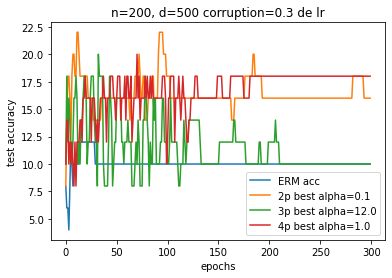

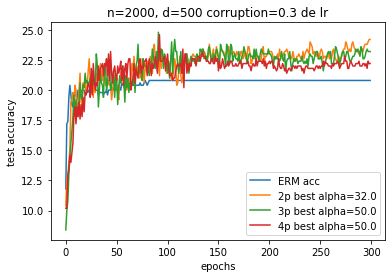

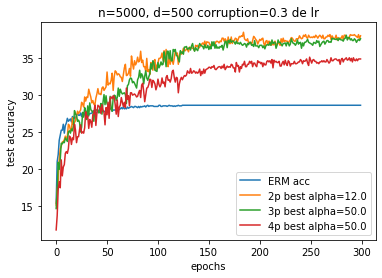

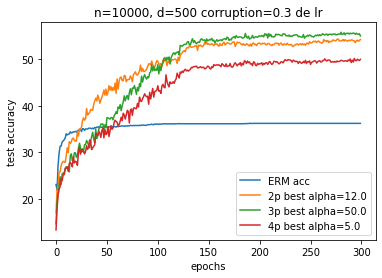

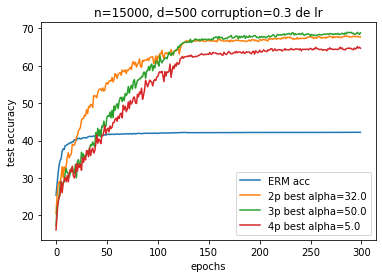

In [ ]:
#################### start training 
for dim in [200]:
  class MLP(torch.nn.Module):
      def __init__(self):
          super(MLP,self).__init__()
          self.fc1 = torch.nn.Linear(dim,800)
          self.fc2 = torch.nn.Linear(800,10)
        
      def forward(self,din):
          dout = torch.nn.functional.relu(self.fc1(din))
          output = self.fc2(dout)
          return output  
  for n in [200,2000,5000,10000,15000]:  
    epochs = 300
    result_dict = defaultdict(list)
    result_lastdict = defaultdict(list)
    result_realdict = defaultdict(list)
    result_corruptdict = defaultdict(list)
    #create files to save results
    f = open('dim={} n={} corruption=0.5.txt'.format(dim, n), 'a')
    m = open('dim={} n={} memorization cor=0.5.txt'.format(dim, n), 'a')
    for run in range(10):     #run 10 times and take avg.
      x,y = sklearn.datasets.make_classification(n_samples=n, n_features=dim, n_informative=dim, n_redundant=0,
					n_repeated=0, n_classes=10, n_clusters_per_class=2, weights=None,
 					flip_y=0, class_sep=1, hypercube=True,shift=0.0, scale=1.0, 
					shuffle=True, random_state=None)

      train_x, train_y, test_x, test_y = balanceclass(0.75 * n, 10, x, y)
      trainy, idx = flipy(train_y, 0.5)        #introduce corrputed labels into current data
      train = data_utils.TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(trainy).float())
      #train = data_utils.TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
      train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)
      test = data_utils.TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())
      test_loader = data_utils.DataLoader(test, batch_size=128, shuffle=False)

####### testing for training memorization on LAST EPOCH, also take average & std     
      trainy_corrupted = trainy[idx]
      trainx_corrupted = train_x[idx]    #extract x with corrupted labels
      trainx_real = np.delete(train_x, idx, 0)
      trainy_real = np.delete(trainy, idx, 0)
      corrupt = data_utils.TensorDataset(torch.from_numpy(trainx_corrupted).float(), torch.from_numpy(trainy_corrupted).float())
      corrupted_loader = data_utils.DataLoader(corrupt, batch_size=128, shuffle=False)
      real = data_utils.TensorDataset(torch.from_numpy(trainx_real).float(), torch.from_numpy(trainy_real).float())
      real_loader = data_utils.DataLoader(real, batch_size=128, shuffle=False)

      trainingmixup()
      trainingERM()
      #start saving every run's best result:
      bestalphas = defaultdict(list)    #only need last run's plot
      bestaccidx = defaultdict(list)
      for name,res in zip(['ERM', '2p', '3p', '4p'], [resultsori, results2, results3, results4]):
        res = np.array([res])[0]
        a = res[:,3].astype(float)    #get all best accs
        globalbest_acc = np.max(a)    #choose the best best test acc among all alpha values
        idx = np.where(a == np.max(a))[0]
        bestaccidx[name].append(idx)
        best_alpha = res[:,1].astype(float)[idx]
        bestalphas[name].append(best_alpha)
        best_epoch = res[:,5].astype(int)[idx]
        print(f'for mixup {name}: global best acc = ', globalbest_acc, 'best alpha = ', best_alpha, 'global best epoch = ', best_epoch)
        result_dict[name].append(globalbest_acc)
        f.write('<{0}  {1}  {2}  {3}  {4} > \n'.format(run, name, globalbest_acc, best_alpha, best_epoch))

      #start saving corruption & memorization result for each run:
      for name, res in zip(['ERM','2p','3p','4p'], [resultsoricorrupt, results2corrupt, results3corrupt, results4corrupt]):
        res = np.array([res])[0]
        line = res[int(bestaccidx[name][0][0])]      #pick out the line with best test acc out of all alphas, if multiple lines, the first one is picked
        last, real, corrupt = line[3], line[5], line[7]
        result_lastdict[name].append(last)
        result_realdict[name].append(real)
        result_corruptdict[name].append(corrupt)
        m.write('<{}  {}  last_test_acc={}  last_real_train={} last_cor_train={}> \n'.format(run, name, last, real, corrupt))
    
    #computing mean over 10 runs
    for i in ['2p','3p','4p','ERM']:
      mean = round(np.mean(result_dict[i]),4)
      std = round(np.std(result_dict[i]),4)
      f.write('start computing mean and std: \n')
      f.write('<{0}  {1}  {2}> \n'.format(i, mean, std))
    f.close()

    #computing mean for last, real, corrupt over 10 runs
    for i in ['2p','3p','4p','ERM']:
      for k,j in zip(['last', 'real', 'corrupt'] ,[result_lastdict, result_realdict, result_corruptdict]):
        mean = round(np.mean(np.array(j[i]).astype(float)),4)
        std = round(np.std(np.array(j[i]).astype(float)),4)
        m.write('start computing mean and std: \n')
        m.write('<{0}  {1}  {2}  {3}> \n'.format(i, k, mean, std))
    m.close()
    #Plot the last run and best alpha, plot the first 300 epochs
    plt.figure()
    plt.title('n={}, d={} corruption=0.5'.format(n,dim))
    plt.plot(np.arange(len(accori)), accori, label = 'ERM acc')
    ba2p = bestalphas['2p'][0][0]
    ba3p = bestalphas['3p'][0][0]
    ba4p = bestalphas['4p'][0][0]
    print('ba4p', ba4p)
    loc2p = np.where([0.1, 1, 8, 12, 32] == ba2p)[0][0]
    loc3p = np.where([0.1, 1, 5, 12, 50] == ba3p)[0][0]  
    loc4p = np.where([0.1, 1, 5, 12, 50] == ba4p)[0][0] 
    print('loc4p', loc4p)
    # plot the test acc over epochs obtained on the last run best alpha
    plt.plot(np.arange(300), acc2p[loc2p*300 : (loc2p+1)*300], label = '2p best alpha={}'.format(ba2p))
    plt.plot(np.arange(300), acc3p[loc3p*300 : (loc3p+1)*300], label = '3p best alpha={}'.format(ba3p))
    plt.plot(np.arange(300), acc4p[loc4p*300 : (loc4p+1)*300], label = '4p best alpha={}'.format(ba4p))
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.savefig('n={} d={} corruption={}.png'.format(n, dim, 0.5))